# Week 6 -- Preparing Dataset and Writing an Face Recognition Preprocessor #

## Required Packages

conda install tensorflow\
conda install jupyterlab\
conda install pip\
conda install opencv\
conda install matplotlib\
pip install requests\


## Prepare Dataset - face recognition

dataset link: http://vis-www.cs.umass.edu/lfw/ 

Information:
13233 images
5749 people
1680 people with two or more images

## code

In [4]:
# import packages
import requests
import tarfile
import os
import numpy as np
import cv2
import keras
from typing import List
print("finish importing!")

# global variable


Using TensorFlow backend.


finish importing!


In [5]:
# install dataset
# note: it could take more than 5 minute to download. If the circle on the upper right of this window is black, DO NOT stop this process untill see
# the output "Downloading finish"
data_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
training_pairs_url = "http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt"
testing_pairs_url = "http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt"
anchor_lib_url = "https://raw.github.com/tensorflow/models/blob/master/research/object_detection/anchor_generators/grid_anchor_generator.py"
zip_dataset_name = "lfw.tgz"
training_pairs_name = "pairsDevTrain.txt"
testing_pairs_name = "pairsDevTest.txt"
data_dir_name = 'data'
if not os.path.isdir(data_dir_name):
    os.mkdir(data_dir_name)
    print("Downloading start")
    r = requests.get(data_url,stream = True)
    with open(os.path.join(data_dir_name, zip_dataset_name), 'wb') as f:
        f.write(r.raw.read())
    print("Downloading finish")
# download pairsDevTrain.txt and parisDevTest.txt
if not os.path.isfile(training_pairs_name):
    r = requests.get(training_pairs_url)
    with open(training_pairs_name, "wb") as file:
        file.write(r.content)
    print(f"{training_pairs_name} Downloaded")
if not os.path.isfile(testing_pairs_name):
    r = requests.get(testing_pairs_url)
    with open(testing_pairs_name, "wb") as file:
        file.write(r.content)
    print(f"{testing_pairs_name} Downloaded")

In [6]:
#unzip the package
if not len([os.listdir('data')]) > 5700:
    tar = tarfile.open("data/lfw.tgz", "r")
    tar.extractall(data_dir_name)
    tar.close
    print("finish extracting")

finish extracting


# Please read closely to the README before going foreward

In [7]:
# http://vis-www.cs.umass.edu/lfw/README.txt

In [8]:
# this function return the path to the image with name NAME_ID.jpg
def construct_dir_from_name(name, id):
    path_name = os.path.join(data_dir_name,"lfw",name)
    return os.path.join(path_name,name) + "_" + f"{id}".zfill(4) + ".jpg"

In [9]:
class DataGenerator (keras.utils.Sequence):
    def __init__(self, txt_file_name, batch_size, anchor_shape = (96,96), channel = 3, shuffle = True):
        print("initializaing")
        self.batch_size = batch_size
        self.anchor_shape = anchor_shape
        self.shuffle = shuffle
        self.txt_file_name = txt_file_name
        self.anchar_arr = []
        self.channel = channel
        self.negative_dir_arr:List[str] = []
        self.positive_dir_arr:List[str] = []
        with open(txt_file_name) as f:
            for line in f:
                line = line.split()
                if len(line) == 3:
                    self.positive_dir_arr.append([construct_dir_from_name(line[0],line[1]), construct_dir_from_name(line[0], line[2])])
                elif len(line) == 4:
                    self.negative_dir_arr.append([construct_dir_from_name(line[0],line[1]),construct_dir_from_name(line[2], line[3])])
        self.on_epoch_end()
        
    # if self.shuffle == true, shuffle the positive and negative indexes
    def on_epoch_end(self):
        # udpate indexs after each epoch
        self.pos_indexes = np.arange(len(self.positive_dir_arr))
        self.neg_indexes = np.arange(len(self.negative_dir_arr))
        if self.shuffle == True:
            np.random.shuffle(self.pos_indexes)
            np.random.shuffle(self.neg_indexes)

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.pos_indexes) / self.batch_size))
    
    def __getitem__(self, index):
        pos_indexes = self.pos_indexes[index*self.batch_size:(index+1)*self.batch_size]
        neg_indexes = self.neg_indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        pos_list_temp = [self.positive_dir_arr[i] for i in pos_indexes]
        neg_list_temp = [self.negative_dir_arr[k] for k in neg_indexes]

        anchor_batch, pos_batch, neg_batch = self.__batch_generation(pos_list_temp,neg_list_temp)
        return anchor_batch, pos_batch, neg_batch
    
    def __batch_generation(self, pos_index_temp, neg_index_temp):
        # construct positive image (numpy) array
        pos_img_arr = []
        neg_img_arr = []
        anchor_arr = [] # todo
        for dir in pos_index_temp:
            img = cv2.imread(dir[1])
            resized_img = cv2.resize(img, self.anchor_shape)
            pos_img_arr.append(resized_img)
        for dir in neg_index_temp:
            img = cv2.imread(dir[0])
            resized_img = cv2.resize(img, self.anchor_shape)
            neg_img_arr.append(resized_img)
        return anchor_arr, pos_img_arr, neg_img_arr
    
    def generate_data(self):
        while(True):
            counter = 0
            yield self[counter]
            counter += 1


In [10]:
# for testing only
data_generator = DataGenerator(txt_file_name=training_pairs_name, batch_size = 6);
anchor_arr, pos_img_arr, neg_img_arr = next(data_generator.generate_data())
print(np.asarray(pos_img_arr).shape)
pos_img_example = pos_img_arr[1]
neg_img_example = neg_img_arr[1]
print("testing complete")

initializaing
(6, 96, 96, 3)
testing complete


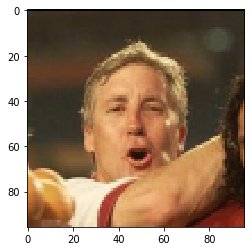

In [11]:
import matplotlib.pyplot as plt
pos_img_example = pos_img_example[:, :, ::-1]
plt.imshow(pos_img_example)

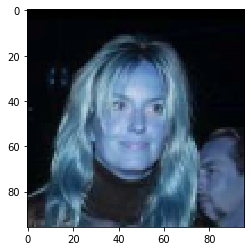

In [12]:
plt.imshow(neg_img_example)

